# Test2 Model Search Analysis

The objective here is to gain insight on short vs. medium lookbacks, variance penalties, and the effect of different volatility powers.

### Necessary Functions and Imports

In [1]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import pandas as pd

import os

def toGridDict(testNum, gridSpecs, gridOrder):
    """
    Converts a param search testing number to the corresponding param dictionary.
    """
    paramDict = {}
    for key in gridOrder:
        n = len(gridSpecs[key])
        rem = testNum % n
        paramDict[key] = gridSpecs[key][int(rem)]
        testNum = (testNum - rem) / n
    return paramDict

def toTestNum(paramDict, gridSpecs, gridOrder):
    """
    Converts a param dictionary to the corresponding param testing number.
    """
    testNum = 0
    currBase = 1
    for key in gridOrder:
        testNum = testNum + currBase * gridSpecs[key].index(paramDict[key])
        n = len(gridSpecs[key])
        currBase = currBase * n
    return testNum

def maxTestNum(gridSpecs, gridOrder):
    """Returns |Theta| for param space Theta."""
    maxTests = 1
    for key in gridOrder:
        maxTests = maxTests * len(gridSpecs[key])
    return maxTests

def initParamResultsDataframe(gridSpecs, gridOrder):
    """
    Instantiates the dataframe to store results of param searching.
    """
    maxTests = maxTestNum(gridSpecs, gridOrder)
    initSharpe = [-1] * maxTests
    initNetValue = [-1] * maxTests
    initTestNum = range(maxTests)
    paramDataDict = {
        'test_idx' : initTestNum,
        'sharpe' : initSharpe,
    }
    prdf = pd.DataFrame(paramDataDict, index=initTestNum)
    return prdf

def storeCurrentParamResults(paramfile_name, df):
    """
    Stores current dataset in DataFrame to datafile_name.csv.
    """
    file_str = paramfile_name + '.csv'
    df.to_csv(file_str, index=False)
    return ('Finished writing to ' + file_str)

def readCurrentParamResults(paramfile_name, gridSpecs, gridOrder):
    """
    Checks and reads paramfile_name.csv for a DataFrame of grid data and progress.
    """
    file_str = paramfile_name + '.csv'
    file_exists = os.path.exists(file_str)
    assert file_exists, 'file does not exist!'
    # if exists:
    prdf = pd.read_csv(file_str)
    maxTests = prdf.shape[0]
    untested_indices = []
    for i in range(maxTests):
        if prdf.sharpe[i] == -1:
            untested_indices.append(prdf.test_idx[i])
    return prdf, untested_indices

### Import Data

In [2]:
param_order = [
    'lookback', 'EMA_eps', 'alpha_w', 'pca_count', 
    'var_penalty', 'var_cap', 'subtr', 'vol_look', 'vol_power',
]
param_specs = {
    "lookback" : [2, 4],
    "EMA_eps" : [0.01],
    "alpha_w" : [[1, 0]], # weights for self preds and "pro" preds
    "pca_count" : [1],
    "var_penalty" : [0.25, 2],
    "var_cap" : [0.01],
    "subtr" : [True],
    "vol_look" : [21],
    "vol_power" : [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
}

sharpe_data = np.zeros((3, 32))
filename_lst = ['full_psearch_7to10yr_2', 'full_psearch_4to5yr_2', 'full_psearch_0to1yr_2']
for i in range(3):
    temp_df = readCurrentParamResults(filename_lst[i], param_specs, param_order)[0]
    sharpe_data[i, :] = np.array(temp_df.sharpe)
print(sharpe_data)

[[1.03417541 0.64614926 1.01280481 0.65569413 1.17329899 0.68023107
  1.20151976 0.67055247 1.25056033 0.62012267 1.1315772  0.59652764
  1.0389257  0.57399774 1.1422468  0.68454607 1.08225351 0.83602763
  1.19648343 0.98183864 1.35509806 0.63265921 1.15705778 0.59707826
  1.27372907 0.63833586 1.73525305 0.80454435 1.51649904 1.03021306
  1.44066439 0.8688267 ]
 [0.8959652  1.06929141 0.70010392 1.05268243 0.82518604 1.19107517
  0.76553411 1.46457342 0.52001713 0.57018557 0.4994245  1.29325215
  0.43283132 1.08894159 0.76127334 1.68460633 0.54571748 1.162835
  0.52529451 0.81329829 0.48681983 1.5069088  0.62489204 1.69544172
  0.68990728 1.37025018 0.26389205 1.39047539 0.75513875 1.51463496
  0.37548742 1.72306782]
 [2.39748145 2.16032311 2.42383616 2.68603265 2.23948134 2.57776041
  2.38298926 2.29605664 2.72269064 2.35857199 2.42459932 2.63776467
  3.21000815 2.75535352 2.39961503 2.05882883 2.81177156 2.85743707
  2.69689973 2.86712145 2.76495211 2.68187664 2.72584822 2.71376464


### Sharpe Plots
Since we only have a param space of size 35, we can (more or less) comfortably plot our performances per config.

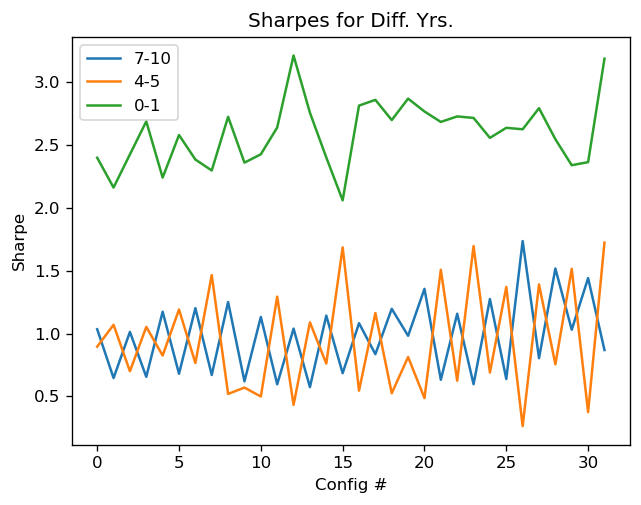

In [3]:
plt.figure(figsize=(6, 4.5), dpi=120)
for i in range(3):
    plt.plot(sharpe_data[i, :])
plt.title('Sharpes for Diff. Yrs.')
plt.xlabel('Config #')
plt.ylabel('Sharpe')
plt.legend(['7-10', '4-5', '0-1'])

We see that years 4-5 are really fucking with patterns. Is there a way around this?

In [4]:
# z-score conversion
z_data = (sharpe_data - np.mean(sharpe_data, axis=1, keepdims=True))/np.std(sharpe_data, axis=1, keepdims=True)

In [5]:
# Rank for best by overall rankings
rank_pts = np.zeros((32, 1))
for i in range(3):
    rank_idx = z_data[i, :].argsort()[::-1] # descending, higher sharpe = better
    print(rank_idx)
    for j in range(32):
        rank_pts[rank_idx[j]] += j
overall_idx = rank_pts[:, 0].argsort()
print(overall_idx)

[26 28 30 20 24  8  6 18  4 22 14 10 16 12  0 29  2 19 31 17 27 15  5  7
  3  1 25 21  9 23 11 13]
[31 23 15 29 21  7 27 25 11  5 17 13  1  3  0  4 19  6 14 28  2 24 22  9
 16 18  8 10 20 12 30 26]
[12 31 19 17 16 27 20 13 22  8 23 18  3 21 11 25 26  5 24 28 10  2 14  0
  6 30  9 29  7  4  1 15]
[31 27 17 19 20 28 22 16  8 23 12 18 24 21 29 26  6  5 25 13  3 14  0 11
  4 15  7  2 30 10  1  9]


In [6]:
# Print the top rankings
for i in range(16):
    print(toGridDict(overall_idx[i], param_specs, param_order))

{'lookback': 4, 'EMA_eps': 0.01, 'alpha_w': [1, 0], 'pca_count': 1, 'var_penalty': 2, 'var_cap': 0.01, 'subtr': True, 'vol_look': 21, 'vol_power': 1.9}
{'lookback': 4, 'EMA_eps': 0.01, 'alpha_w': [1, 0], 'pca_count': 1, 'var_penalty': 2, 'var_cap': 0.01, 'subtr': True, 'vol_look': 21, 'vol_power': 1.7}
{'lookback': 4, 'EMA_eps': 0.01, 'alpha_w': [1, 0], 'pca_count': 1, 'var_penalty': 0.25, 'var_cap': 0.01, 'subtr': True, 'vol_look': 21, 'vol_power': 1.3}
{'lookback': 4, 'EMA_eps': 0.01, 'alpha_w': [1, 0], 'pca_count': 1, 'var_penalty': 2, 'var_cap': 0.01, 'subtr': True, 'vol_look': 21, 'vol_power': 1.3}
{'lookback': 2, 'EMA_eps': 0.01, 'alpha_w': [1, 0], 'pca_count': 1, 'var_penalty': 0.25, 'var_cap': 0.01, 'subtr': True, 'vol_look': 21, 'vol_power': 1.5}
{'lookback': 2, 'EMA_eps': 0.01, 'alpha_w': [1, 0], 'pca_count': 1, 'var_penalty': 0.25, 'var_cap': 0.01, 'subtr': True, 'vol_look': 21, 'vol_power': 1.9}
{'lookback': 2, 'EMA_eps': 0.01, 'alpha_w': [1, 0], 'pca_count': 1, 'var_penalt

The top runs here are good to check for candidates, in particular, the third config was tested on 10 years and is not bad.

### Group Statistics
Here, we aim to compare the results from grouping data by parameter (singly).

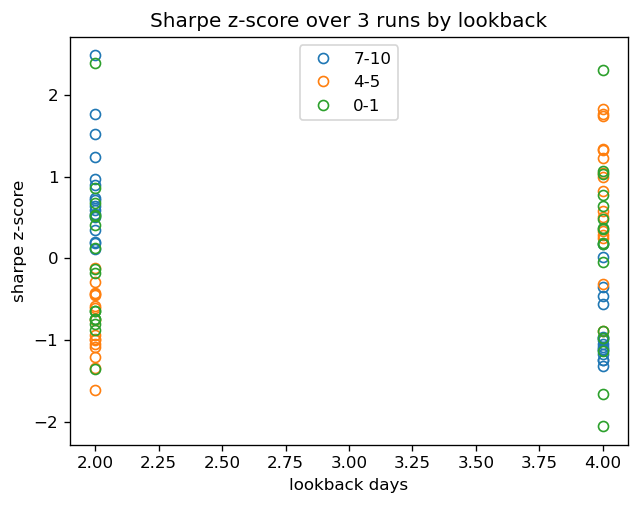

In [9]:
lookback_pos = []
for i in range(32):
    temp_dict = toGridDict(i, param_specs, param_order)
    lookback_pos.append(temp_dict['lookback'])
plt.figure(figsize=(6, 4.5), dpi=120)
for i in range(3):
    plt.plot(lookback_pos, z_data[i, :], 'o', mfc='none')
plt.title('Sharpe z-score over 3 runs by lookback')
plt.xlabel('lookback days')
plt.ylabel('sharpe z-score')
plt.legend(['7-10', '4-5', '0-1'])

Fill in

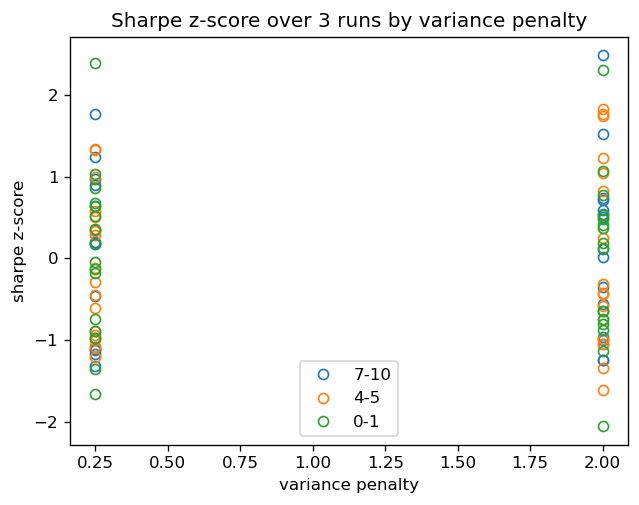

In [10]:
penalty_pos = []
for i in range(32):
    temp_dict = toGridDict(i, param_specs, param_order)
    penalty_pos.append(temp_dict['var_penalty'])
plt.figure(figsize=(6, 4.5), dpi=120)
for i in range(3):
    plt.plot(penalty_pos, z_data[i, :], 'o', mfc='none')
plt.title('Sharpe z-score over 3 runs by variance penalty')
plt.xlabel('variance penalty')
plt.ylabel('sharpe z-score')
plt.legend(['7-10', '4-5', '0-1'])

Fill in.

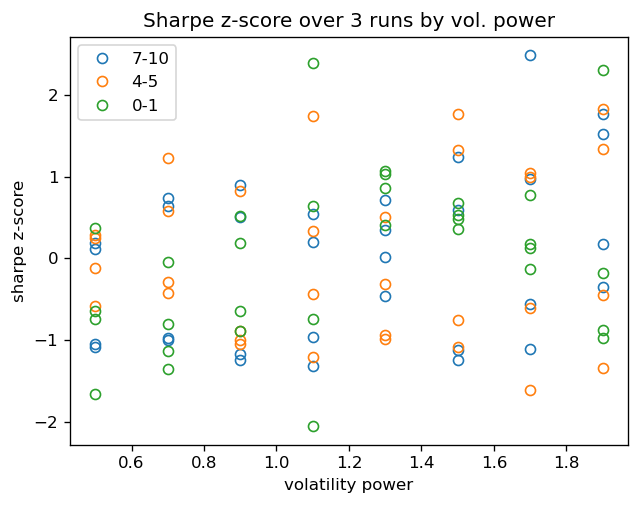

In [13]:
vol_pos = []
for i in range(32):
    temp_dict = toGridDict(i, param_specs, param_order)
    vol_pos.append(temp_dict['vol_power'])
plt.figure(figsize=(6, 4.5), dpi=120)
for i in range(3):
    plt.plot(vol_pos, z_data[i, :], 'o', mfc='none')
plt.title('Sharpe z-score over 3 runs by vol. power')
plt.xlabel('volatility power')
plt.ylabel('sharpe z-score')
plt.legend(['7-10', '4-5', '0-1'])